# Convolutional Neural Networks (CNNs)

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Mohammadjavad Maheronnaghsh

In this homework, you will work with [Google colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on Google servers using a GPU/TPU. To enable GPU support, make sure to press `Runtime -> Change Runtime Type -> GPU`.

## Task: Cats vs Dogs

To learn about CNNs we will be working on a problem of great importance in computer vision, **classifying images of cats and dogs** :)

The problem is so important that there's even an easter egg in colab: go to `Tools -> Settings -> Miscellaneous and enable 'Kitty mode' and 'Corgi mode'` to get more cats and dogs to classify when you're tired of coding :)

### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [2]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2024-04-03 08:54:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 142.250.1.207, 108.177.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   107MB/s    in 0.6s    

2024-04-03 08:54:12 (107 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
! unzip -q cats_and_dogs_filtered.zip

### Dataset Organization
Our dataset contains two directories, `train` and `validation`, both containing two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats and 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a CNN to classify these images, i.e. given an image from this dataset, tell if it contains a *cat* or a *dog*.

```bash
├── dir.txt
├── train
│   ├── cats
│   │   ├── cat.0.jpg
│   │   ├── cat....jpg
│   │   ├── cat.999.jpg
│   └── dogs
│       ├── dog.0.jpg
│       ├── dog....jpg
│       ├── dog.999.jpg
├── validation
│   ├── cats
│   │   ├── cat.2000.jpg
│   │   ├── cat....jpg
│   │   └── cat.2499.jpg
│   └── dogs
│       ├── dog.2000.jpg
│       ├── dog....jpg
│       └── dog.2499.jpg
└── vectorize.py

6 directories, 3002 files
```

### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

 Torchvision is a Pytorch library with many commonly used tools in computer vision. In the case of computer vision, the datasets with the folder structure `label_name/image_file` are very common, and to process those there's already an implemented class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)).

 Another thing we need from Torchvision library is [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html). In computer vision, we very often want to transform the images in certain ways. The most common is **normalization**. Others include *flipping*, changing *saturation*, *hue*, *contrast*, *rotation*, and *blurring*.

 Below, we create training, validation and test sets. We use a few transforms for **augmentation** on the training set, but we don't use anything but **resize** and **normalization** for validation and test.

In [4]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Inverse transformation which is needed for plotting.
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=Image.Resampling.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(), # This is necessary to convert PIL to torch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms)

validation_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [500, 500], generator=torch.Generator().manual_seed(42))

### Dataset Inspection
Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

torch.Size([3, 256, 256])


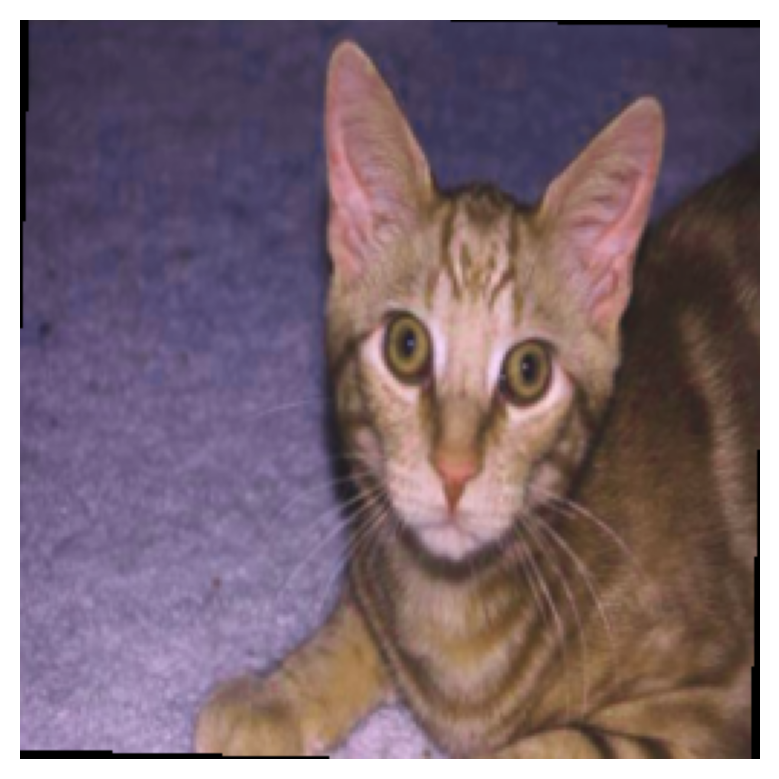

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(inv_normalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

print(train_dataset[10][0].shape)
show_normalized_image(train_dataset[10][0])

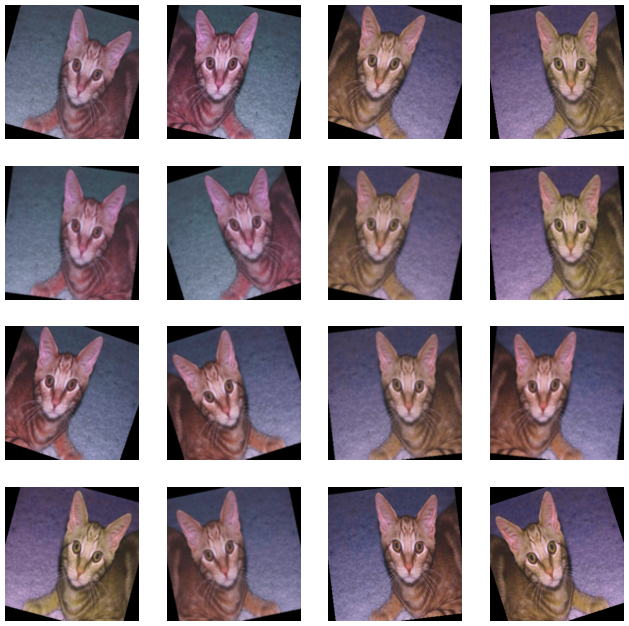

In [6]:
# checking the augmentation
plt.rcParams['figure.dpi'] = 50
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    show_normalized_image(train_dataset[10][0])
plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating the model

Now is the time to create a model.

All models in Pytorch are subclassing `torch.nn.Module`. We have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a CNN containing the following elements:

* Convolutional layers (at least two)
* Pooling layers
* Non-linearity
* Residual connections similar to that of **ResNet**
* fully connected layer(s)

Note that you cannot use Batch Normalization layers in this step.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_cat_dog(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv_residual = nn.Conv2d(3, 64, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # print("Input shape:", x.shape)
        residual = self.conv_residual(x)
        residual = self.pool(residual)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = x + residual
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [9]:
model = CNN_cat_dog()
model.to(device)

CNN_cat_dog(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_residual): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU(inplace=True)
)

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [10]:
from tqdm.notebook import tqdm
import torch.optim as optim

def get_loss_and_correct(model, batch, criterion, device):
    # Implement forward pass and loss calculation for one batch.
    # Remember to move the batch to device.
    #
    # Return a tuple:
    # - loss for the batch (Tensor)
    # - number of correctly classified examples in the batch (Tensor)
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return loss, correct


def step(loss, optimizer):
    # Implement backward pass and update.
    # TODO
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
N_EPOCHS = 10 # TODO
BATCH_SIZE = 64 # TODO

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN_cat_dog()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model.train()

    for batch in tqdm(train_dataloader, leave=False):
        # use `get_loss_and_correct` to perform a step and save train loss and corrects
        # TODO
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct

    with torch.no_grad():
        for batch in validation_dataloader:
            # use `get_loss_and_correct` to perform a step and save validation loss and corrects
            # TODO
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct

    mean_train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataset)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

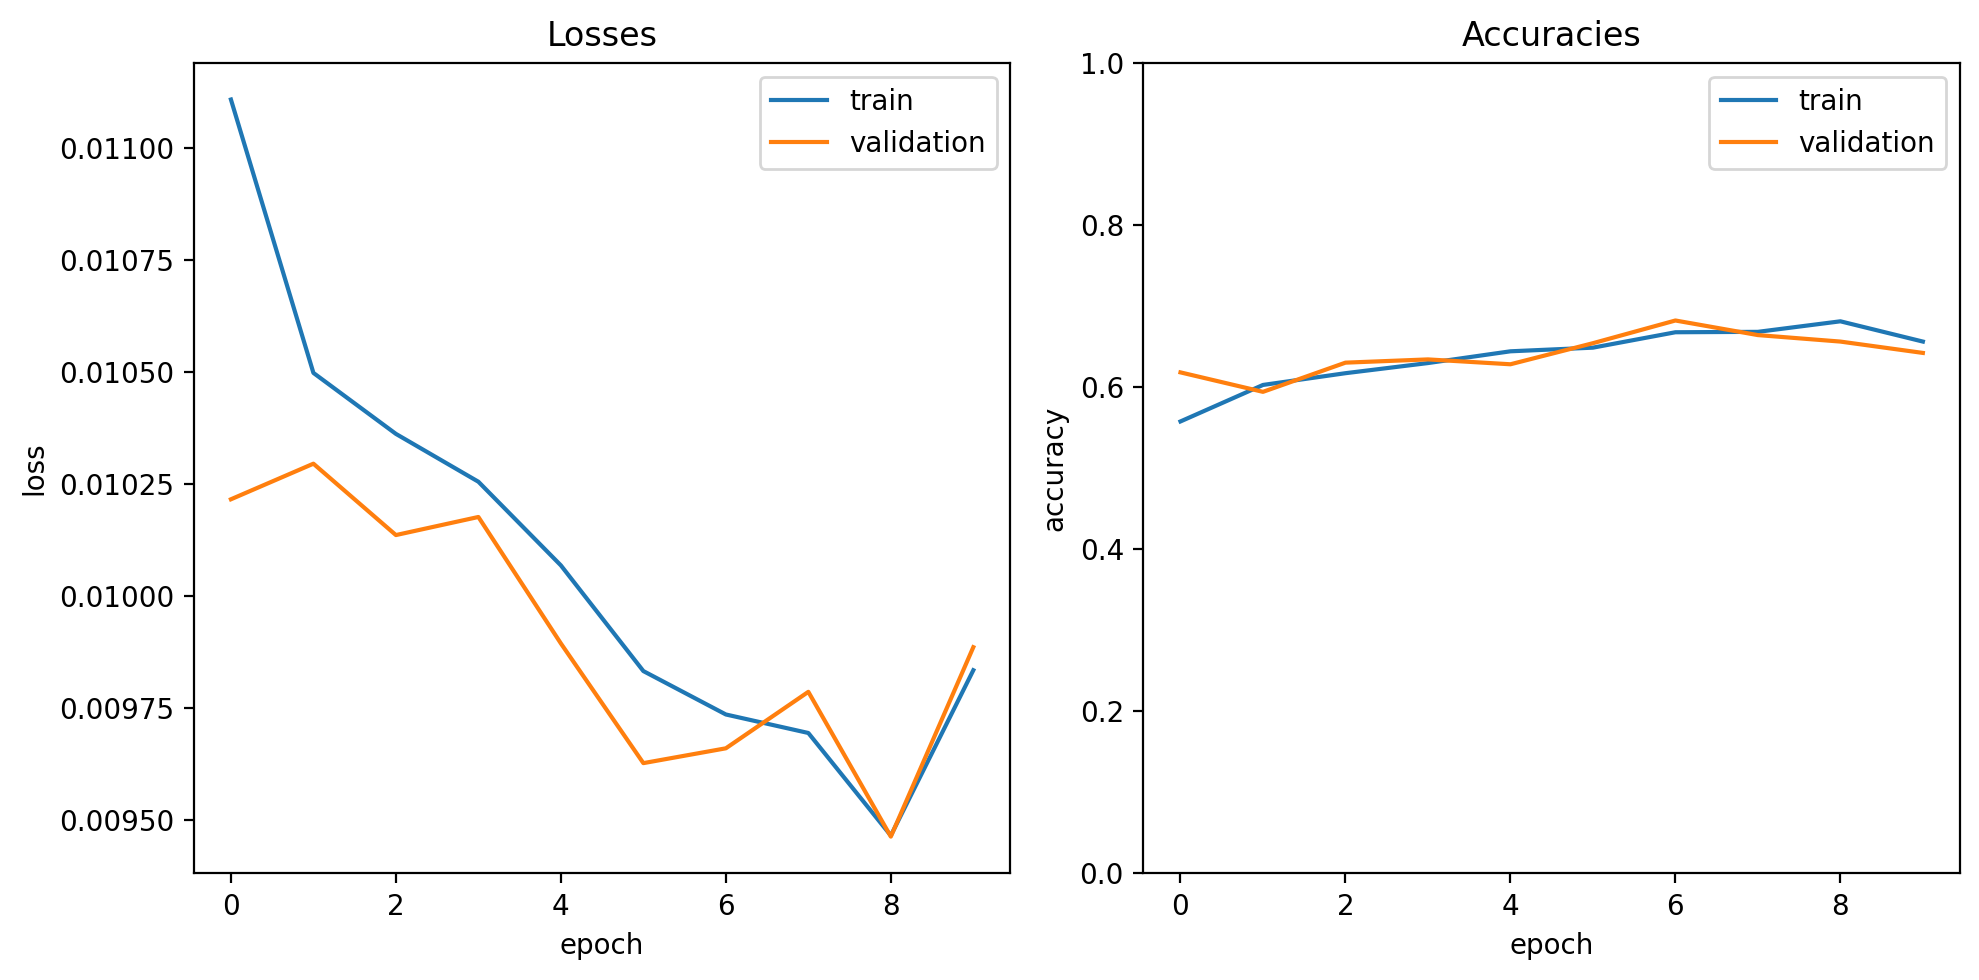

In [ ]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

Now, change your model to achieve at least 75% accuracy on validation set. Add Dropout and Batch Norm layers where needed. You can change the model you've implemented (including the model depth, activation functions, etc.), the optimizer (including the regularizer terms), and the augmentations.

#### Question
Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

In the following, you can see my 3 models and corresponding experiences. In each of them, I tried to make a better version of the model, in the last one (modeified_3), I used these techniques:
- batch norm
- drop out
- more layers
- augmentation
- Adam optimizer

I can see overfit on the 3rd model (and also the 2nd one), because it memorizes the valid and training but fails on testing, this gap between the validation and test accuracy shows the overfitting, but i tried to make the epochs less (8 for the 3rd model) and it's now better.
Also, the acc_val-acc_train plot helps us in identifying the overfitting situation.


## Experiment 1

In [ ]:
class CNN_cat_dog_modified(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv_residual = nn.Conv2d(3, 64, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # print("Input shape:", x.shape)
        residual = self.conv_residual(x)
        residual = self.pool(residual)
        # residual = self.bn2(residual)
        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = x + residual
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# Change your model to achieve better accuracies
# TODO
N_EPOCHS = 30 # TODO
BATCH_SIZE = 64 # TODO

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN_cat_dog_modified()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

model = model.cuda()
criterion = criterion.cuda()
device = torch.device("cuda:0")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model.train()

    for batch in tqdm(train_dataloader, leave=False):
        # use `get_loss_and_correct` to perform a step and save train loss and corrects
        # TODO
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct

    with torch.no_grad():
        for batch in validation_dataloader:
            # use `get_loss_and_correct` to perform a step and save validation loss and corrects
            # TODO
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct

    mean_train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataset)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

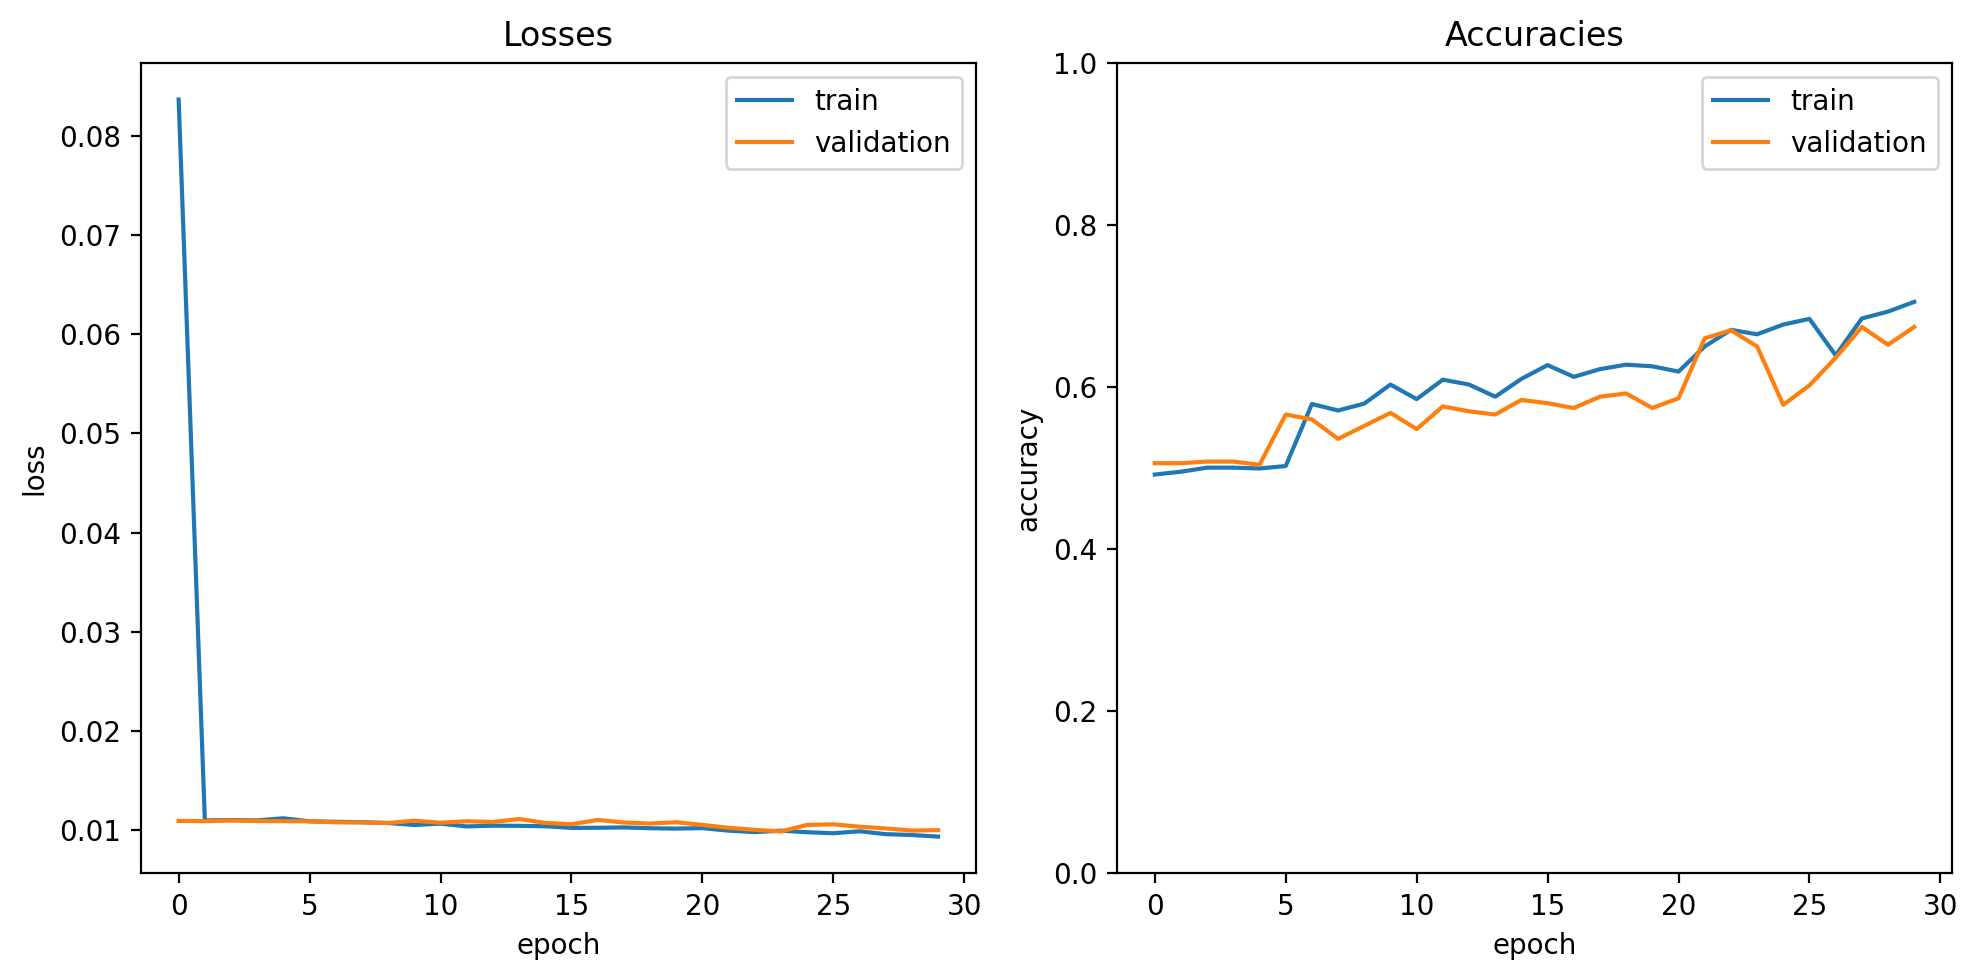

In [ ]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

## Experiment 2

In [ ]:
class CNN_cat_dog_modified_2(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv_residual = nn.Conv2d(3, 64, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes//2)
        self.fc3 = nn.Linear(num_classes//2, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # print("Input shape:", x.shape)
        residual = self.conv_residual(x)
        residual = self.pool(residual)
        residual = self.bn2(residual)
        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = x + residual
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [ ]:
# Change your model to achieve better accuracies
# TODO
N_EPOCHS = 50 # TODO
BATCH_SIZE = 64 # TODO

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model_2 = CNN_cat_dog_modified_2()
model_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

model_2.train()

model_2 = model_2.cuda()
criterion = criterion.cuda()
device = torch.device("cuda:0")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model_2.train()

    for batch in tqdm(train_dataloader, leave=False):
        # use `get_loss_and_correct` to perform a step and save train loss and corrects
        # TODO
        loss, correct = get_loss_and_correct(model_2, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct

    with torch.no_grad():
        for batch in validation_dataloader:
            # use `get_loss_and_correct` to perform a step and save validation loss and corrects
            # TODO
            loss, correct = get_loss_and_correct(model_2, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct

    mean_train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataset)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

## Experiment 3

In [11]:
class CNN_cat_dog_modified_3(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv_residual = nn.Conv2d(3, 64, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        residual = self.conv_residual(x)
        residual = self.pool(residual)
        residual = self.bn2(residual)
        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = x + residual
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Change your model to achieve better accuracies
# TODO
from torch.utils.data import ConcatDataset
from tqdm.notebook import tqdm
import torch.optim as optim

N_EPOCHS = 8
BATCH_SIZE = 64


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet statistics
])

train_dataset_for_augmentation = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transform)
original_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
augmented_dataset_repeated = ConcatDataset([train_dataset_for_augmentation] * 4)
final_dataset = ConcatDataset([original_dataset, augmented_dataset_repeated])



total_samples = len(final_dataset)
print(total_samples)
split_ratio = 0.2
split_lengths = [int(total_samples * split_ratio), total_samples - int(total_samples * split_ratio)]
validation_dataset_augmented, train_dataset_augmented = torch.utils.data.random_split(final_dataset, split_lengths, generator=torch.Generator().manual_seed(42))

print(f'size of valid: {len(validation_dataset_augmented)} and size of train: {len(train_dataset_augmented)}')
train_dataloader = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset_augmented, batch_size=BATCH_SIZE, num_workers=2)
model_3 = CNN_cat_dog_modified_3()
model_3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

model_3.train()

model_3 = model_3.cuda()
criterion = criterion.cuda()
device = torch.device("cuda:0")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model_3.train()

    for batch in tqdm(train_dataloader, leave=False):
        loss, correct = get_loss_and_correct(model_3, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct

    with torch.no_grad():
        for batch in validation_dataloader:
            loss, correct = get_loss_and_correct(model_3, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct

    mean_train_loss = total_train_loss / len(train_dataset_augmented)
    train_accuracy = total_train_correct / len(train_dataset_augmented)

    mean_validation_loss = total_validation_loss / len(validation_dataset_augmented)
    validation_accuracy = total_validation_correct / len(validation_dataset_augmented)

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

10000
size of valid: 2000 and size of train: 8000


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

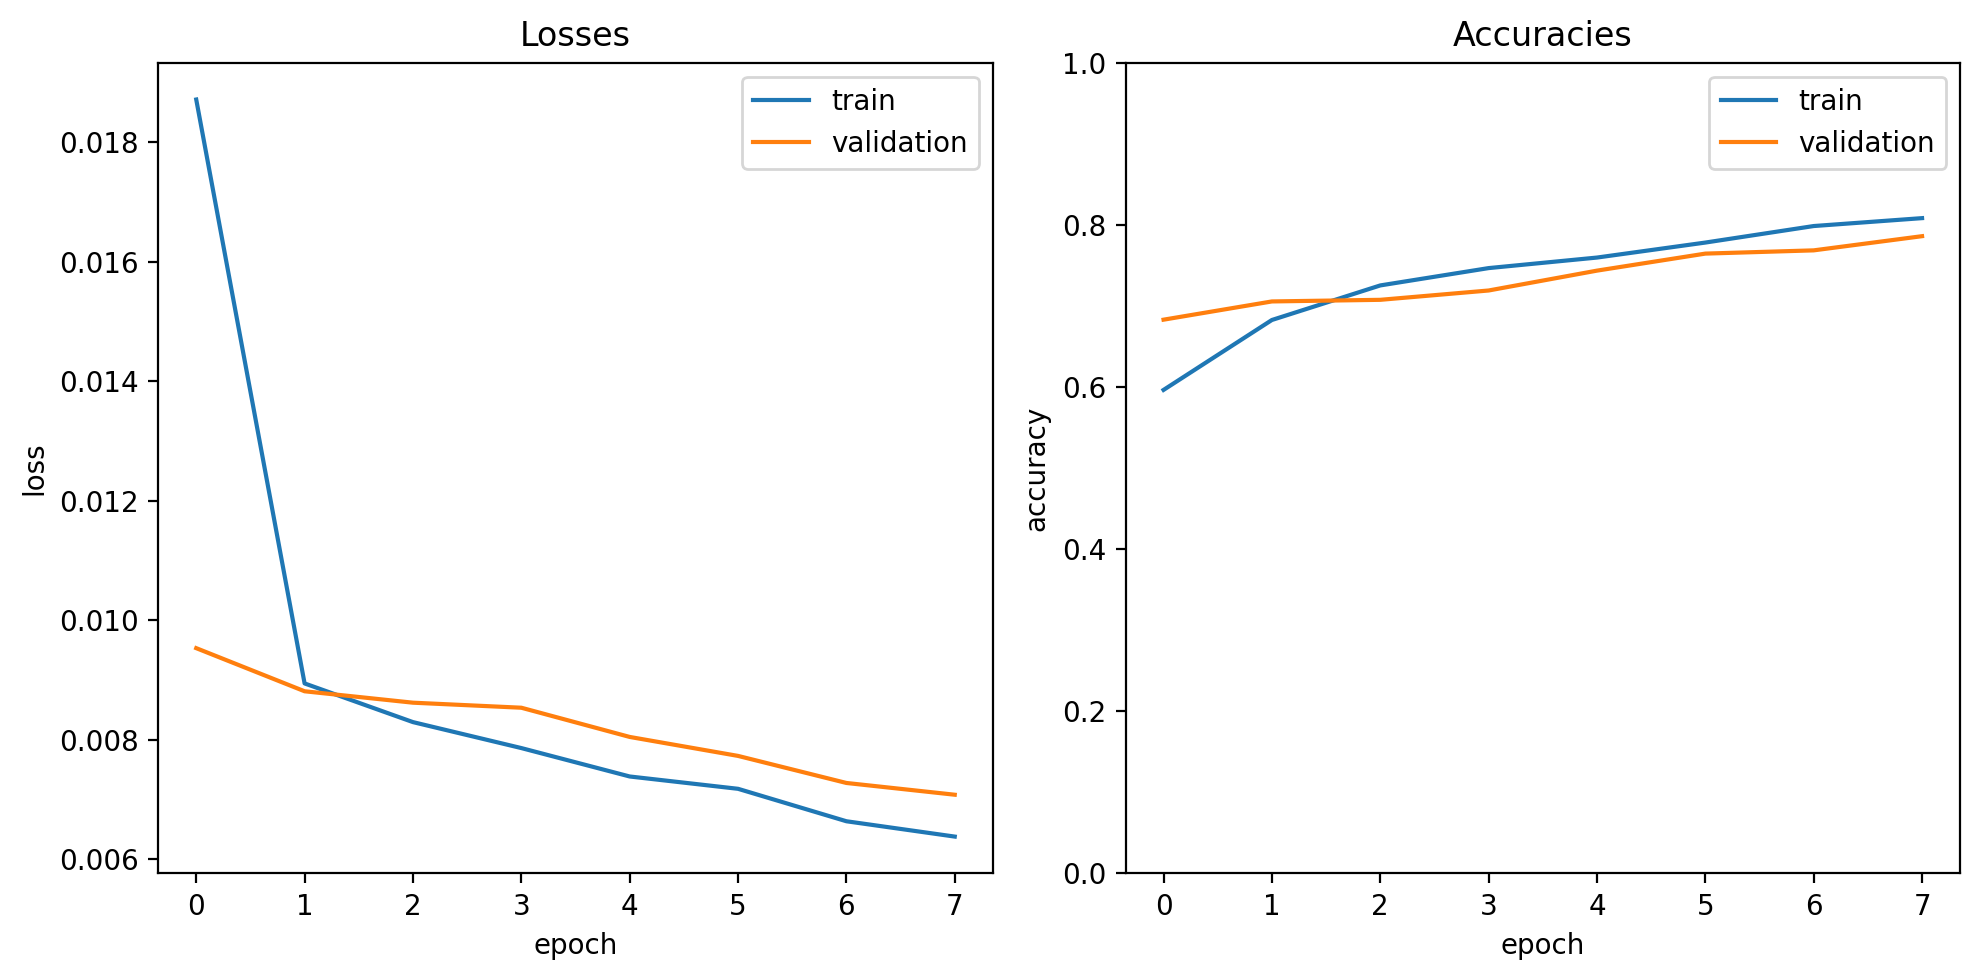

In [13]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

Test Dataset Accuracy: 71.00%
Correctly Classified Examples:


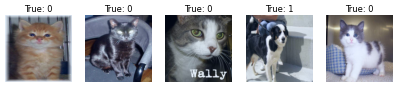

Incorrectly Classified Examples:


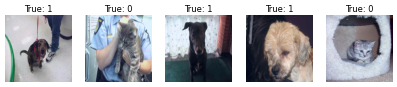

In [14]:
def evaluate_model(model, test_loader, device, num_examples=5):
    model.eval()
    correct_examples = []
    incorrect_examples = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                if predicted[i] == labels[i]:
                    correct_examples.append((images[i].cpu(), labels[i].cpu()))
                else:
                    incorrect_examples.append((images[i].cpu(), labels[i].cpu()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Dataset Accuracy: {accuracy:.2f}%")

    print("Correctly Classified Examples:")
    plt.figure(figsize=(10, 4))
    for i in range(min(num_examples, len(correct_examples))):
        plt.subplot(2, num_examples, i + 1)
        image = correct_examples[i][0].permute(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())
        plt.imshow(image)
        plt.title(f"True: {correct_examples[i][1]}")
        plt.axis('off')
    plt.show()

    print("Incorrectly Classified Examples:")
    plt.figure(figsize=(10, 4))
    for i in range(min(num_examples, len(incorrect_examples))):
        plt.subplot(2, num_examples, i + 1)
        image = incorrect_examples[i][0].permute(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())
        plt.imshow(image)
        plt.title(f"True: {incorrect_examples[i][1]}")
        plt.axis('off')
    plt.show()

batch_size_test = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# evaluate_model(model, test_loader, device)
# evaluate_model(model_2, test_loader, device)
evaluate_model(model_3, test_loader, device)

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

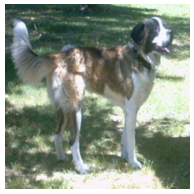

In [15]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [32]:
# generate the intermediate output and print its shape
input = validation_dataset[10][0].unsqueeze(0).to(device)

clipped1 = nn.Sequential(*list(model_3.children())[:1])  # Clip after the first 2 layers
clipped2 = nn.Sequential(*list(model_3.children())[:4])  # Clip after the first 5 layers

intermediate_output1 = clipped1(input)
intermediate_output2 = clipped2(input)

print("Intermediate output 1 shape:", intermediate_output1.shape)
print("Intermediate output 2 shape:", intermediate_output2.shape)

Intermediate output 1 shape: torch.Size([1, 32, 256, 256])
Intermediate output 2 shape: torch.Size([1, 64, 256, 256])


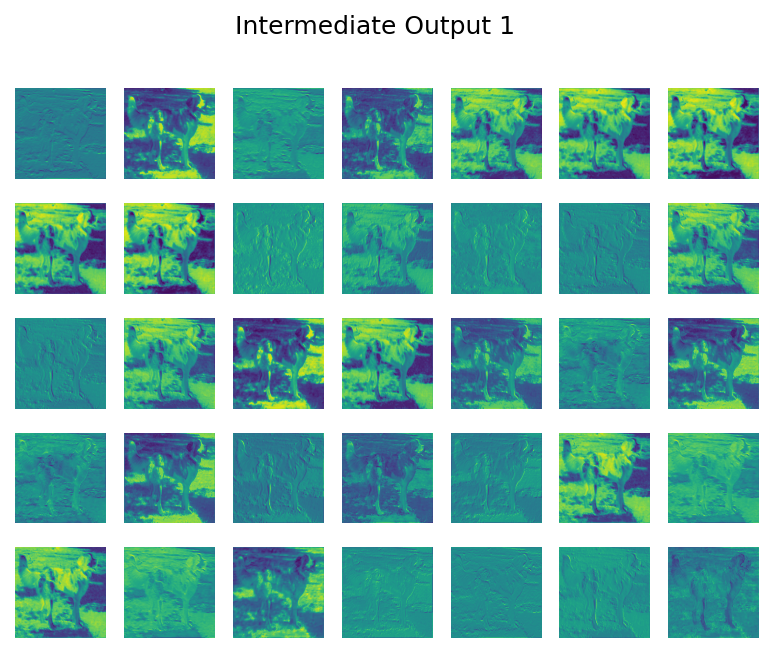

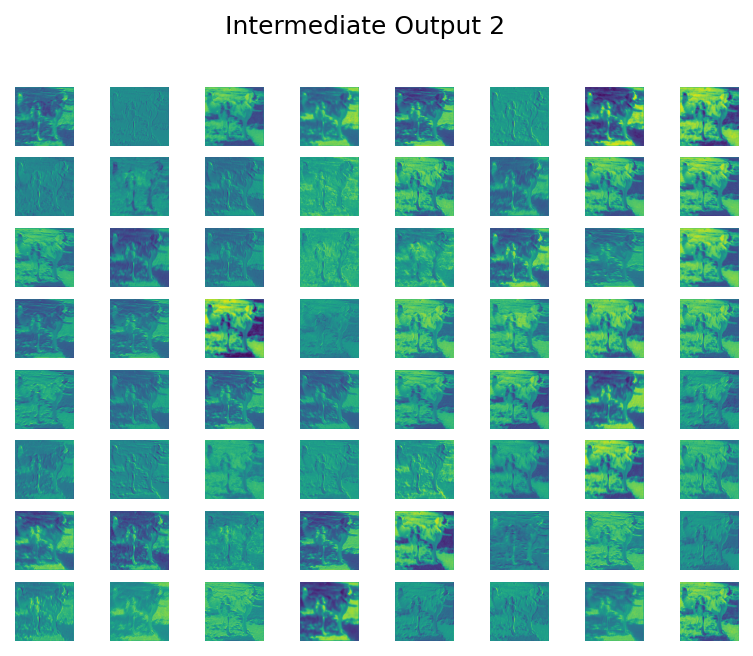

In [33]:
import math

def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

# TODO:
# pick a few intermediate representations from your
# network and plot them using the provided function.
plot_intermediate_output(intermediate_output1, title="Intermediate Output 1")
plot_intermediate_output(intermediate_output2, title="Intermediate Output 2")

plt.show()

### Question
What can you say about those filters? What features are they focusing on?
As you can see, as we go farther in a model, we can extract more human-readable things.
As we delve deeper in the model, we can see better-structured outputs. For instance, in the first layers we may see data about edge, etc but in the last layers we can see data about the whole concept of the output.

In the 2nd image, we can see a focus on specific parts of data.